In [1]:
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from module import plot_data, find_total_spectrum, get_q_data, integrate
import urllib.request

Finding valid isotopes in root tree

In [2]:
# reading all possible decays (except alpha)
beta_minus_isotopes = pd.read_csv('beta-.csv')
beta_plus_isotopes = pd.read_csv('beta+.csv')
electron_capture_isotopes = pd.read_csv('electron_capture.csv')
beta_minus_isotopes['a'] = beta_minus_isotopes['z'] + beta_minus_isotopes['n']
beta_plus_isotopes['a'] = beta_plus_isotopes['z'] + beta_plus_isotopes['n']
electron_capture_isotopes['a'] = electron_capture_isotopes['z'] + electron_capture_isotopes['n']

# reading data from root tree
file = uproot.open('DEAP-3600_full_450M_muons_cosm_nuclei.root')
tree = file['Data']
branches = ['muonEnergy', 'muonX', 'muonY', 'muonZ', 'muoncosX', 'muoncosY', 'muoncosZ', 'depositeEnergyInVeto', 'depositeEnergyInLAr', 'depositeEnergyInGAr', 'ResIZ', 'ResIA', 'ResIS', 'ResX', 'ResY', 'ResZ', 'Region']

# convert root tree into pd.DataFrame
df = tree.arrays(branches, library = 'pd')
df = pd.DataFrame(df.to_numpy(), columns = df.columns)

# explode all lists of events and filter them (leaving only LAr events)
list_cols = ['ResIZ','ResIA','ResIS','ResX','ResY','ResZ','Region']
df_exploded = df.explode(list_cols, ignore_index=True)
lar_events = df_exploded[df_exploded['Region'] == 'LAr'].copy()
rename = {'ResIZ':'z', 'ResIA':'a'}
lar_events.rename(columns = rename, inplace = True)

# merging events and decays by isotopes (A, Z)
beta_plus = lar_events.merge(beta_plus_isotopes, on = ['z', 'a'], how= 'left')
beta_minus = lar_events.merge(beta_minus_isotopes, on = ['z', 'a'], how = 'left')
electron_capture = lar_events.merge(electron_capture_isotopes, on = ['z', 'a'], how = 'left')
beta_minus = beta_minus[beta_minus['betaMinus(keV)'] > 9000]
beta_plus = beta_plus[beta_plus['positronEmission(keV)'] > 9000]
electron_capture = electron_capture[electron_capture['electronCapture(keV)'] > 9000]

# counting unique isotopes and delete copies
beta_minus['count'] = beta_minus.groupby(['z', 'a'])['z'].transform('count')
beta_minus_unique = beta_minus.drop_duplicates(subset = ['z', 'a']).reset_index(drop = True)
beta_plus['count'] = beta_plus.groupby(['z', 'a'])['z'].transform('count')
beta_plus_unique = beta_plus.drop_duplicates(subset = ['z', 'a']).reset_index(drop = True)

# set index of dataset to (a, z)
beta_minus_unique = beta_minus_unique.set_index(['a', 'z'])
beta_plus_unique = beta_plus_unique.set_index(['a', 'z'])

# rename decay type to merge all types of decays
rename = {'betaMinus(keV)': 'total_decay_energy'}
beta_minus_unique.rename(columns = rename, inplace = True)

# final dataset
final_data = beta_minus_unique

In [3]:
final_data

,,muonEnergy,muonX,muonY,muonZ,muoncosX,muoncosY,muoncosZ,depositeEnergyInVeto,depositeEnergyInLAr,depositeEnergyInGAr,ResIS,ResX,ResY,ResZ,Region,n,total_decay_energy,count
a,z,,,,,,,,,,,,,,,,,,
9,3,1018.59137,26.696474,-463.940491,1550.0,-0.004462,0.247364,-0.968912,86.585144,328.898685,0.00021,0,19.512226,-60.689445,-28.196001,LAr,6.0,13606.4541,3
13,5,1445.439819,554.766663,-543.151001,1550.0,-0.287577,0.301796,-0.908966,9.41671,11.95468,0.0,0,53.099442,-13.705935,-60.060154,LAr,8.0,13436.9387,1
8,3,1445.439819,554.766663,-543.151001,1550.0,-0.287577,0.301796,-0.908966,9.41671,11.95468,0.0,0,70.643745,-26.009247,-3.667388,LAr,5.0,16004.1329,10
26,11,2654.605469,249.96669,67.614799,1550.0,-0.135177,-0.034634,-0.990216,33.812729,44.999507,0.003106,0,38.480862,3.396106,50.185238,LAr,15.0,9353.7631,3
16,7,1342.765015,-340.658813,129.511383,1550.0,0.187288,-0.066277,-0.980067,135.835029,210.335931,0.009965,0,-53.307217,24.635731,-24.108177,LAr,9.0,10420.9094,2
12,5,205.116211,418.416565,364.046967,1550.0,-0.240054,-0.172354,-0.955337,11.678138,0.881862,0.00012,0,-15.284652,32.999977,50.313339,LAr,7.0,13369.3979,2


In [4]:
symbol_map = {
     1: 'H',   2: 'He',  3: 'Li',  4: 'Be',  5: 'B',
     6: 'C',   7: 'N',   8: 'O',   9: 'F',  10: 'Ne',
    11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P',
    16: 'S',  17: 'Cl', 18: 'Ar', 19: 'K',  20: 'Ca',
    21: 'Sc', 22: 'Ti', 23: 'V', 24: 'Cr', 25: 'Mn',
    26: 'Fe', 27: 'Co', 28: 'Ni', 29: 'Cu', 30: 'Zn',
}

In [5]:
# setting constants
plt.rcParams.update({'font.size': 14})
result_data = {}
q_rate = 100

In [6]:
BASE_URL = "https://nds.iaea.org/relnsd/v1/data"
HEADERS = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0'}

def fetch_spectrum(A, Z, beta_type='bm'):

    symbol = symbol_map[Z].lower()
    nuclide = f"{A}{symbol}"
    params = f"fields=bin_beta&nuclides={nuclide}&rad_types={beta_type}"
    url = f"{BASE_URL}?{params}"
    req = urllib.request.Request(url, headers=HEADERS)

    with urllib.request.urlopen(req) as resp:
        df = pd.read_csv(resp, comment='#')  

    return df[['bin_en','dn_de_nu']].rename(columns={'bin_en':'Energy','dn_de_nu':'dN/dE'})


spectra = {}
for (A,Z), row in final_data.iterrows():
    spectra[A,Z] = fetch_spectrum(A, Z, beta_type='bm')

In [7]:

for a, z in spectra:
    isotope = str(a) + symbol_map[z]
    N = final_data.at[(a, z), 'count']
    energy_shift = final_data.at[(a, z), 'total_decay_energy']
    result_data[isotope] = get_q_data(spectra[(a, z)], N, energy_shift, norm = 431)

Plotting every isotope`s spectrum

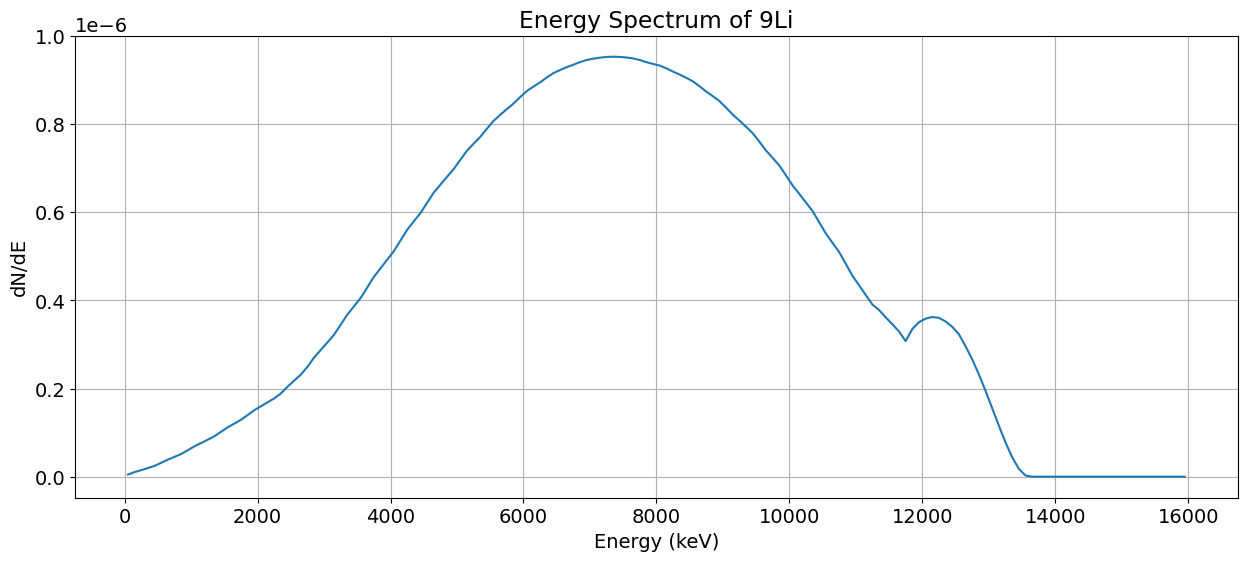

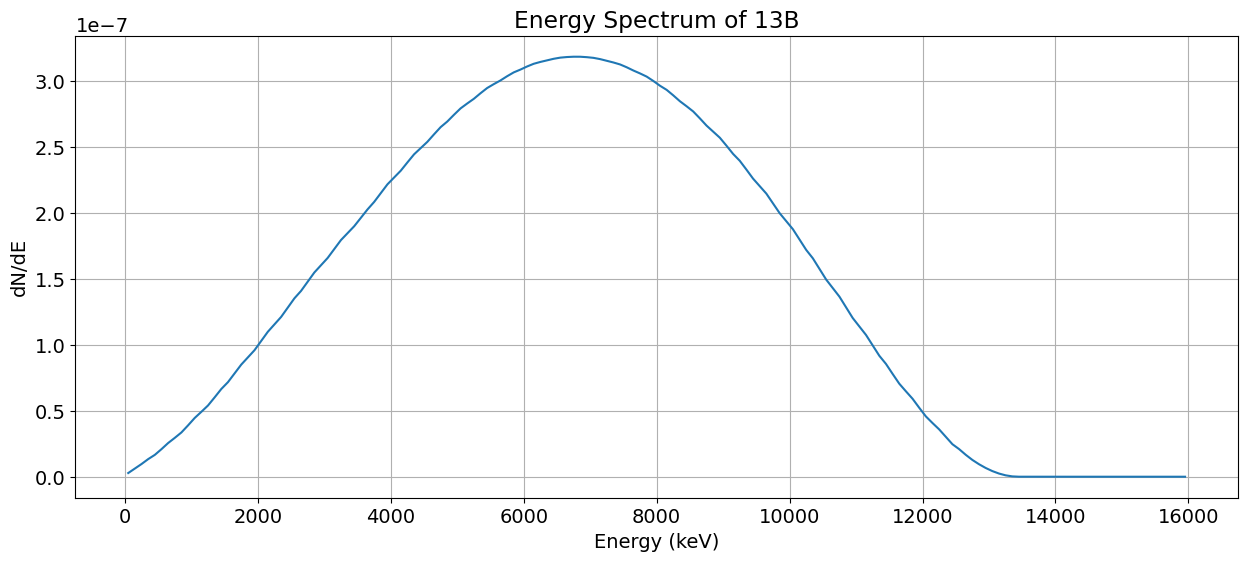

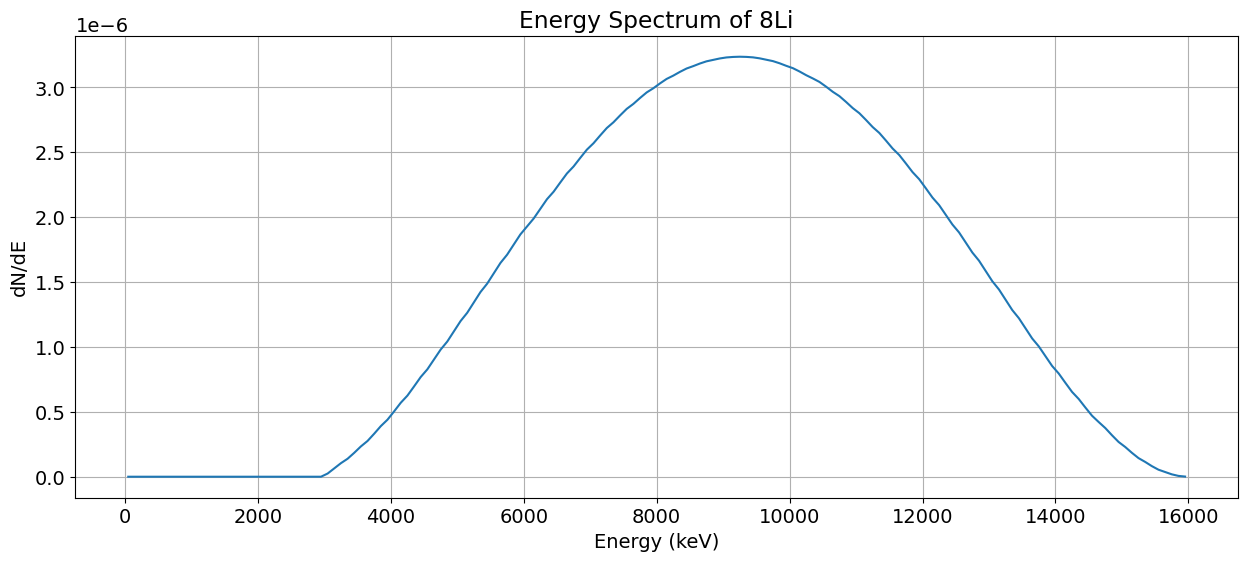

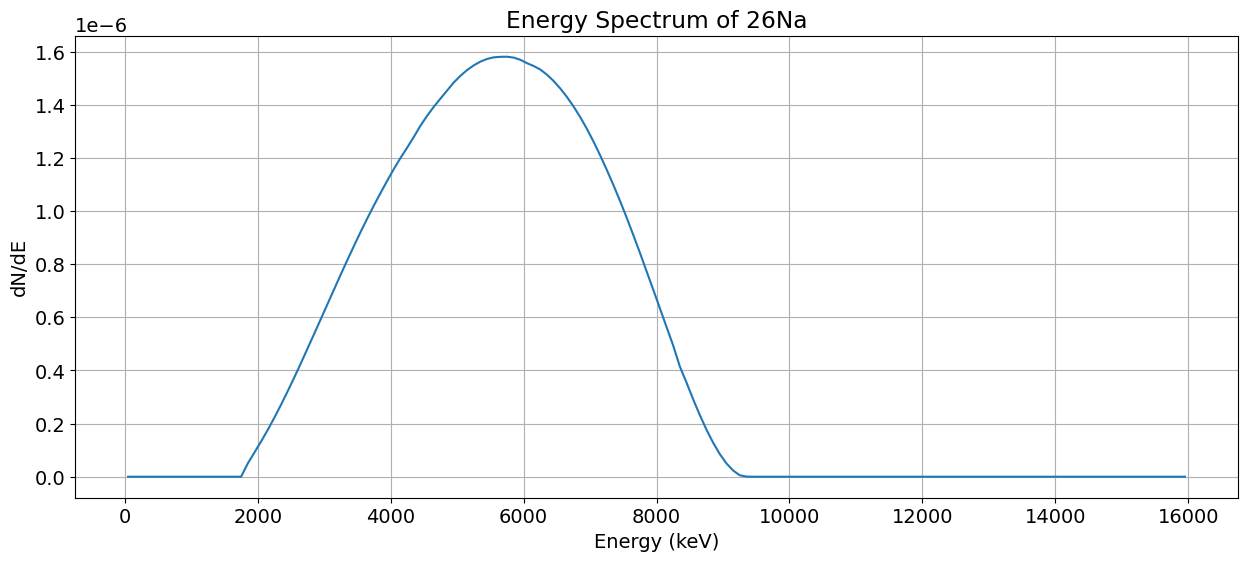

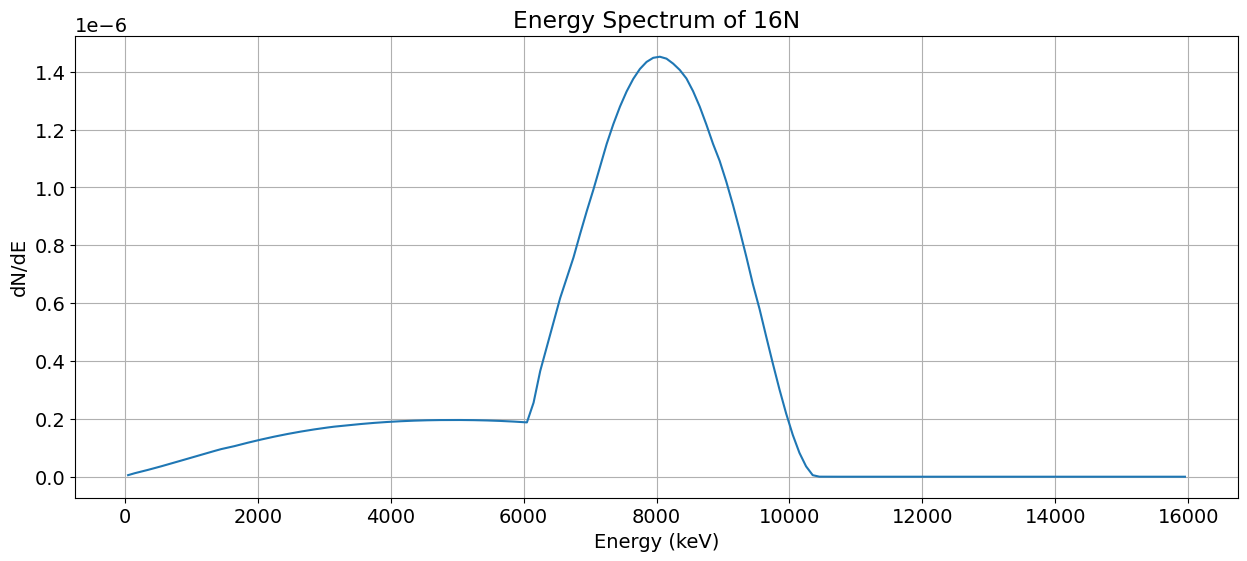

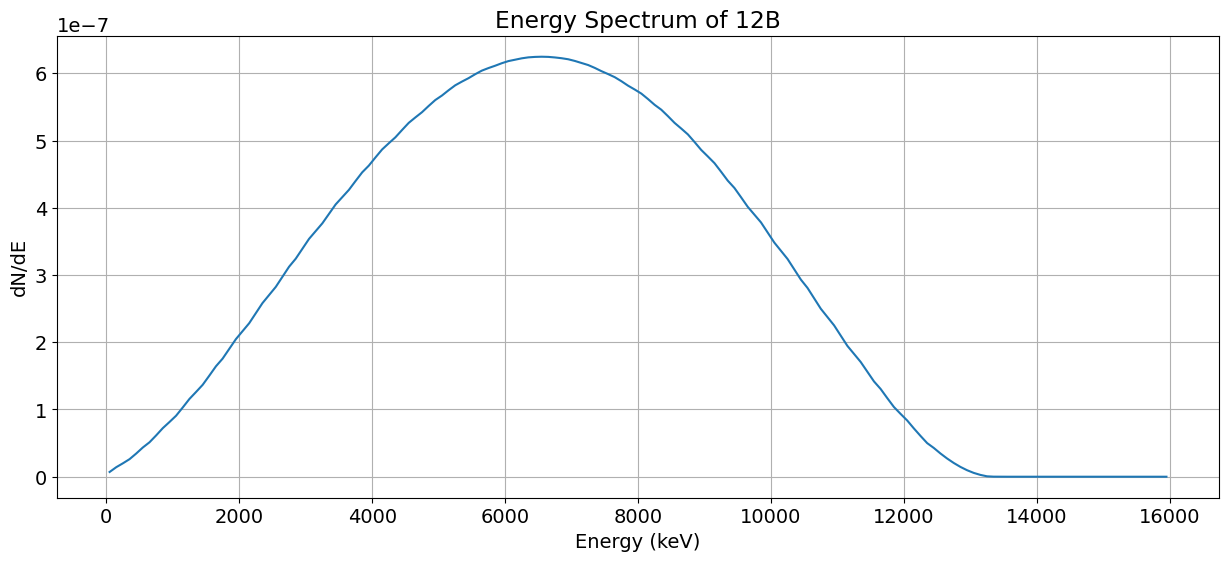

In [8]:

for isotope in result_data:
    df = result_data[isotope]
    plot_data(isotope, df, save_fig=True)
    

Computing and plotting total spectrum

In [ ]:
total_spectrum = find_total_spectrum(result_data, plot = True, save_fig=True)

In [10]:
x = total_spectrum['Energy']
y = total_spectrum['total_dN/dE']

prob = integrate(10500, 13000, x, y, q_rate, 365 / 815)
prob

np.float64(0.01640503128630173)

In [ ]:
from scipy.stats import poisson, norm
from tqdm import tqdm

num_isotopes = len(result_data.keys())
num_iterations = 100000

poisson_distributions = [poisson(mu = final_data.at[(a, z), 'count']) for (a, z) in spectra]
time_distribution = norm(loc=431.1, scale=11.8)

results = np.zeros(num_iterations)

for i in tqdm(range(num_iterations)):
    # generate a random number of isotopes
    isotope_counter = [poisson_distributions[j].rvs() for j in range(num_isotopes)]
    # generate a random time
    time = time_distribution.rvs()

    # compute data for each isotope
    for isotope_idx, (a, z) in enumerate(spectra):
        isotope = str(a) + symbol_map[z]
        N = isotope_counter[isotope_idx]
        energy_shift = final_data.at[(a, z), 'total_decay_energy']
        result_data[isotope] = get_q_data(spectra[(a, z)], N, energy_shift, norm = time)
    
    # find total spectrum
    total_spectrum = find_total_spectrum(result_data, save_fig=False)
    x = total_spectrum['Energy']
    y = total_spectrum['total_dN/dE']

    # compute probability for this iteration of monte carlo
    prob = integrate(10500, 13000, x, y, q_rate, 365 / 815)
    results[i] = prob
    

print(f"Probability of detection: {np.mean(results):.5f} +/- {np.std(results):.5f}")

  8%|▊         | 8349/100000 [05:51<1:05:47, 23.22it/s]